# Simple Recurrent Network

Proof of concept of an Elman-style recurrent network.

In this notebook we will attempt to learn the polka. That is, we will learn to ouput the pattern 0, 0, 1 in time.

In [1]:
import conx as cx

Using TensorFlow backend.
Conx, version 3.6.1


We contruct a Simple Recurrent Network manually. The context bank is an input containing a copy of the activations of the hidden layer from the previous step.

In [2]:
net = cx.Network("Polka in Time")
net.add(
    cx.Layer("input", 1),
    cx.Layer("context", 5),
    cx.Layer("hidden", 5, activation="sigmoid"),
    cx.Layer("output", 1, activation="sigmoid"),
)
net.connect("input", "hidden")
net.connect("context", "hidden")
net.connect("hidden", "output")
net.compile(error="mse", optimizer="sgd", lr=0.1, momentum=0.1)

<IPython.core.display.Javascript object>


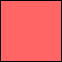
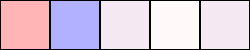
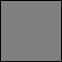
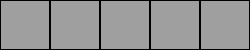

In [3]:
net.picture([[0], [0.5 for i in range(5)]])

In [4]:
net.propagate_to("hidden", (0, [0.5 for i in range(5)]))

[0.43001019954681396,
 0.5765328407287598,
 0.4803524911403656,
 0.4961409866809845,
 0.5249341726303101]

We construct a dataset without context activations. We will compute the context activations dynamically.

 Sequence | Input  | Target
-- | -- | --
$t_0$ | 0  | 0
$t_1$ | 0  | 1
$t_2$ | 1  | 0

In [5]:
dataset = [
    [[0], [0]],
    [[0], [1]],
    [[1], [0]],
]

We can propagate the entire dataset sequence by chaining the context from propagate to propagate:

In [6]:
def propagate_sequence(context, dataset):
    for inputs,targets in dataset:
        context = net.propagate_to("hidden", [inputs, context])
    return context

In [7]:
propagate_sequence([0.5 for i in range(5)], dataset)

[0.2822723984718323,
 0.5038191080093384,
 0.43483442068099976,
 0.36388200521469116,
 0.36754152178764343]

To train the network, we need to construct a new dataset for each batch:

In [8]:
def build_batch_dataset(context, dataset):
    batch_dataset = []
    for inputs,targets in dataset:
        batch_dataset.append([[inputs,context], targets])
        context = net.propagate_to("hidden", [inputs, context])
    return batch_dataset

In [9]:
build_batch_dataset([0.5 for i in range(5)], dataset)

[[[[0], [0.5, 0.5, 0.5, 0.5, 0.5]], [0]],
 [[[0],
   [0.43001019954681396,
    0.5765328407287598,
    0.4803524911403656,
    0.4961409866809845,
    0.5249341726303101]],
  [1]],
 [[[1],
   [0.4268150329589844,
    0.5677814483642578,
    0.4959152042865753,
    0.5093596577644348,
    0.5431210398674011]],
  [0]]]

For these tests, we will replace the net.dataset for each batch:

In [10]:
net.dataset.load(
    build_batch_dataset(context=[0.5 for i in range(5)],
                        dataset=dataset))

A test to make sure everything matches up:

In [11]:
net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
context (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 6)            0           input[0][0]                      
                                                                 context[0][0]                    
__________________________________________________________________________________________________
hidden (Dense)                  (None, 5)            35          concatenate_1[0][0]              
__________

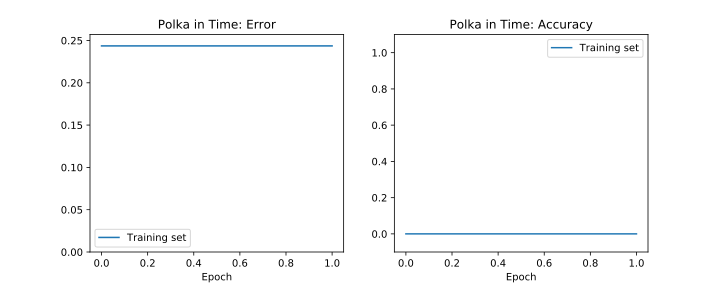

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#    1 |   0.24361 |   0.00000 


In [12]:
net.reset()
net.train(1)

Now we are ready to see if we can learn the polka. There would be no way to learn the sequence if it did not use its memory. Why? Because if you look at the dataset, 50% of the time a 0 input should produce a 0 output, and the other half of the time it should produce a 1 output.

In [13]:
from IPython.display import clear_output

In [14]:
def train(net, epochs, dataset, clear_context=True, report_rate=1, *args, **kwargs):
    context = initial_context = [0.5 for i in range(5)]
    for epoch in range(epochs):
        net.dataset.load(build_batch_dataset(context, dataset))
        total_epochs, results = net.train(1, plot=False, verbose=0, *args, **kwargs)
        if epoch % report_rate == 0:
            clear_output(wait=True)
            net.plot_results()
        if clear_context:
            context = initial_context
        else:
            context = propagate_sequence(context, dataset)
        if "accuracy" in kwargs:
            if results["acc"] >= kwargs["accuracy"]:
                break
    clear_output(wait=True)
    net.plot_results()

In [15]:
net.reset()

In [16]:
train(net, 25000, dataset, accuracy=1.0, report_rate=100)

KeyboardInterrupt: 

In [17]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=0.5, continuous_update=False, description='Zoom', layout=Layout(width='65%'), max=1.0, style=SliderStyle(description_width='initial')), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=True, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=True, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('',), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=1.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=3, options=('input', 'context', 'hidden', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPIBAY8AAK8AANAAAAIC8wAAbwAAsAAAkAAA0Pr2+vPn8wAAVkdH/7a2///X1yYm/2Zm/3h4/5aW/9fX//8VFf8mJv84OP9WVv9nZ/+Ghv+YmP+2thYW/zU1/1hY/4aG/6Wl/8jI//9GRv92dv+mpv/FxX8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

## SimpleRNNLayer

Version 1, with return_sequences=True, followed by time_distributed outputs.

In [18]:
import conx as cx

In [46]:
net = cx.Network("Polka SimpleRNN v1")
net.add(
    cx.Layer("Input", (None, 1,)), 
    cx.SimpleRNNLayer("SimpleRNNLayer", 5, return_sequences=True),
    cx.Layer("Output", 1, activation="sigmoid", time_distributed=True),
)

'Output'

In [47]:
net.connect()

In [48]:
net.compile(error="mse", optimizer="sgd", lr=0.1, momentum=0.1)

In [49]:
net.propagate([[0]])

[0.5]

In [50]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, None, 1)           0         
_________________________________________________________________
SimpleRNNLayer (SimpleRNN)   (None, None, 5)           35        
_________________________________________________________________
Output (TimeDistributed)     (None, None, 1)           6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [51]:
net.dataset.load([
    [[[0], [0], [1], [0], [0], [1]],  # inputs
     [[0], [1], [0], [0], [1], [0]]], # targets
])

In [52]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=0.5, continuous_update=False, description='Zoom', layout=Layout(width='65%'), max=1.0, style=SliderStyle(description_width='initial')), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('',), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=1.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=2, options=('Input', 'SimpleRNNLayer', 'Output'), rows=1, value='Output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPIBAY8AAK8AANAAAAIC8wAAbwAAsAAAkAAA0Pr2+vPn8wAAVkdH/7a2///X1yYm/2Zm/3h4/5aW/9fX//8VFf8mJv84OP9WVv9nZ/+Ghv+YmP+2thYW/zU1/1hY/4aG/6Wl/8jI//9GRv92dv+mpv/FxX8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

In [53]:
net.reset()

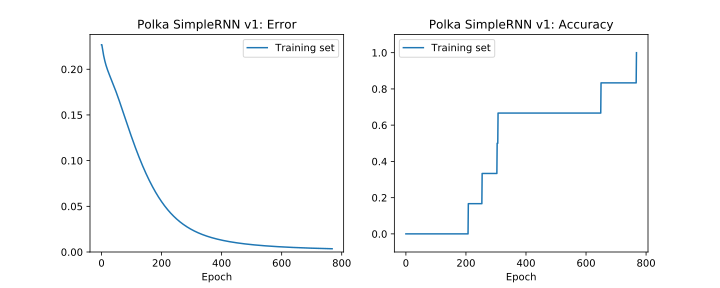

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#  768 |   0.00354 |   1.00000 


In [54]:
net.train(1000, accuracy=1.0, report_rate=100)

In [55]:
net.propagate([[0], [0], [1], [0], [0], [1]])

[[0.09985078871250153],
 [0.9136437177658081],
 [0.029675891622900963],
 [0.038782741874456406],
 [0.9651163816452026],
 [0.013751726597547531]]

# SimpleRNNLayer

Version 2, stateful, with batch_shape.

In [56]:
net = cx.Network("Polka SimpleRNN v2")
net.add(
    cx.Layer("Input", (3, 1), batch_shape=(1,3,1)), 
    cx.SimpleRNNLayer("SimpleRNNLayer", 5, stateful=True),
    cx.Layer("Output", 1, activation="sigmoid"),
)

'Output'

In [57]:
net.connect()

In [58]:
net.compile(error="mse", optimizer="sgd", lr=0.1, momentum=0.1)

In [59]:
net.propagate([[0], [0], [1]])

[0.7131502032279968]

In [60]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (1, 3, 1)                 0         
_________________________________________________________________
SimpleRNNLayer (SimpleRNN)   (1, 5)                    35        
_________________________________________________________________
Output (Dense)               (1, 1)                    6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [61]:
net.dataset.load([
    [[[0], [0], [1]], [0]], 
    [[[0], [1], [0]], [1]], 
    [[[1], [0], [0]], [0]], 
])

In [62]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=0.5, continuous_update=False, description='Zoom', layout=Layout(width='65%'), max=1.0, style=SliderStyle(description_width='initial')), IntText(value=300, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('',), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=1.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=2, options=('Input', 'SimpleRNNLayer', 'Output'), rows=1, value='Output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPIBAY8AAK8AANAAAAIC8wAAbwAAsAAAkAAA0Pr2+vPn8wAAVkdH/7a2///X1yYm/2Zm/3h4/5aW/9fX//8VFf8mJv84OP9WVv9nZ/+Ghv+YmP+2thYW/zU1/1hY/4aG/6Wl/8jI//9GRv92dv+mpv/FxX8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

In [63]:
net.reset()

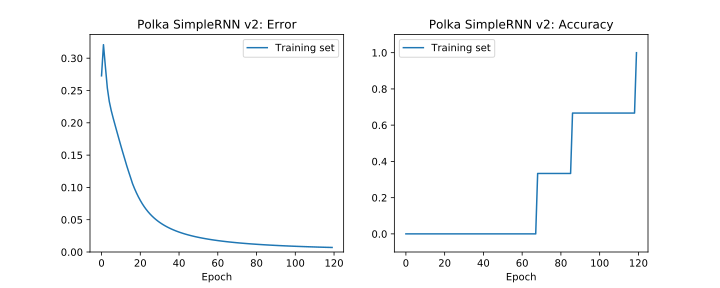

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#  119 |   0.00701 |   1.00000 


In [64]:
net.train(3000, batch_size=1, shuffle=False, report_rate=100, accuracy=1.0)

In [65]:
net.propagate([[0], [0], [1]])

[0.0817810520529747]

In [66]:
net.propagate([[0], [1], [0]])

[0.9011977314949036]

In [67]:
net.propagate([[1], [0], [0]])

[0.06532536447048187]

## SimpleRNN

Version 3, stripped down to defaults.

In [69]:
net = cx.Network("Polka SimpleRNN v3")
net.add(
    cx.Layer("Input", (None, 1)), 
    cx.SimpleRNNLayer("SimpleRNNLayer", 5),
    cx.Layer("Output", 1, activation="sigmoid"),
)

'Output'

In [70]:
net.connect()

In [71]:
net.compile(error="mse", optimizer="sgd", lr=0.1, momentum=0.1)

In [72]:
net.propagate([[0]])

[0.5]

In [73]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, None, 1)           0         
_________________________________________________________________
SimpleRNNLayer (SimpleRNN)   (None, 5)                 35        
_________________________________________________________________
Output (Dense)               (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [74]:
net.dataset.load([
    [[[0], [0], [1]], [0]],
    [[[0], [1], [0]], [1]],
    [[[1], [0], [0]], [0]],
    [[[0], [0], [1]], [0]],
    [[[0], [1], [0]], [1]],
    [[[1], [0], [0]], [0]],
])

In [75]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=0.5, continuous_update=False, description='Zoom', layout=Layout(width='65%'), max=1.0, style=SliderStyle(description_width='initial')), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('',), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=1.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=2, options=('Input', 'SimpleRNNLayer', 'Output'), rows=1, value='Output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPIBAY8AAK8AANAAAAIC8wAAbwAAsAAAkAAA0Pr2+vPn8wAAVkdH/7a2///X1yYm/2Zm/3h4/5aW/9fX//8VFf8mJv84OP9WVv9nZ/+Ghv+YmP+2thYW/zU1/1hY/4aG/6Wl/8jI//9GRv92dv+mpv/FxX8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

<IPython.core.display.Javascript object>

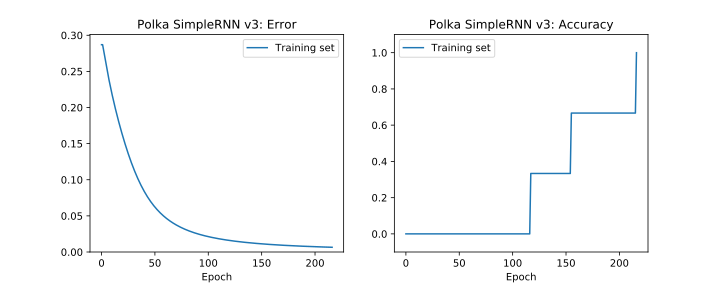

       |  Training |  Training 
Epochs |     Error |  Accuracy 
------ | --------- | --------- 
#  216 |   0.00654 |   1.00000 


In [76]:
net.train(3000, report_rate=100, accuracy=1.0)

In [77]:
net.propagate([[0], [1], [0]])

[0.9004933834075928]

In [78]:
net.propagate([[0]])

[0.42433592677116394]

In [79]:
net.propagate([[0], [1]])

[0.08651964366436005]

In [80]:
net.propagate([[0], [1], [0]])

[0.9004933834075928]